In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/MyDrive/', force_remount = True)

Mounted at /content/MyDrive/


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

Num GPUs Available:  1


In [3]:
!pwd

/content


In [4]:
!ls

MyDrive  sample_data


In [5]:
%cd MyDrive/MyDrive/Colab Notebooks/

/content/MyDrive/MyDrive/Colab Notebooks


In [6]:
!pip install split-folders

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.applications import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, classification_report
from sklearn.model_selection import train_test_split
from imutils import paths

import matplotlib.pyplot as plt
import seaborn as sb
import splitfolders
import cv2
import random

In [9]:
inputFolder = './image_dataset_(Brain)'
outputFolder = './image_dataset_(Brain)_output'
# inputFolder = '/content/GoogleDrive/MyDrive/Colab Notebooks/Neural Networks/Graduation Project/Brain Cancer'
# outputFolder = '/content/GoogleDrive/MyDrive/Colab Notebooks/Neural Networks/Graduation Project/image_dataset_(Brain) '

In [10]:
splitfolders.ratio(inputFolder, outputFolder, seed = 44, ratio = (0.8, 0.0, 0.2))

Copying files: 0 files [00:00, ? files/s]


In [16]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
from imutils import paths

trainFolder = os.path.join(inputFolder, 'train')
testFolder = os.path.join(inputFolder, 'test')

# Get image paths separately for train and test
train_imgPaths = list(paths.list_images(trainFolder))
test_imgPaths = list(paths.list_images(testFolder))

print(f"Train images: {len(train_imgPaths)}")
print(f"Test images: {len(test_imgPaths)}")

# Shuffle paths
random.shuffle(train_imgPaths)
random.shuffle(test_imgPaths)

# Get class names dynamically from train folder
classes = sorted(os.listdir(trainFolder))  # safer and dynamic
print("Classes:", classes)

IMGSIZE = 128

X_train, y_train, img_names = [], [], []
X_test, y_test = [], []

# Processing training data
for imgPath in train_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    # img = cv2.imread(imgPath)
    # print(f"Processing: {imgPath}")
    img = cv2.imread(imgPath)
    if img is None:
        print(f"Warning: Failed to read image {imgPath}")
        continue  # skip this image

    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_train.append(img)
    y_train.append(classes.index(className))
    img_names.append(os.path.basename(imgPath))

# Processing testing data
for imgPath in test_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_test.append(img)
    y_test.append(classes.index(className))

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


Train images: 16010
Test images: 4040
Classes: ['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
16010 16010
4040 4040


In [17]:
df = pd.DataFrame({
    'File Name' : img_names,
    'Category' : y_train #y
})

# print(classes.index('brain_menin'))
# print(classes.index('brain_glioma'))
# print(classes.index('brain_pituitary'))
# print(classes.index('no_tumor'))

print(classes)
df.head()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


,File Name,Category
0,no_tumor_train_1981.jpg,3
1,no_tumor_train_1724.jpg,3
2,brain_tumor_4952.jpg,2
3,brain_menin_1031.jpg,1
4,no_tumor_train_1744.jpg,3


<Axes: ylabel='count'>

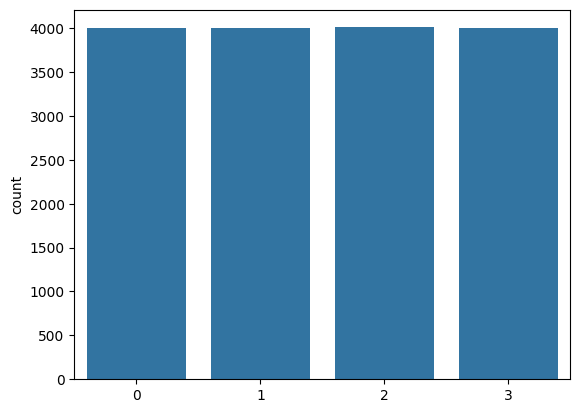

In [18]:
sb.countplot(x = y_train)

<Axes: ylabel='count'>

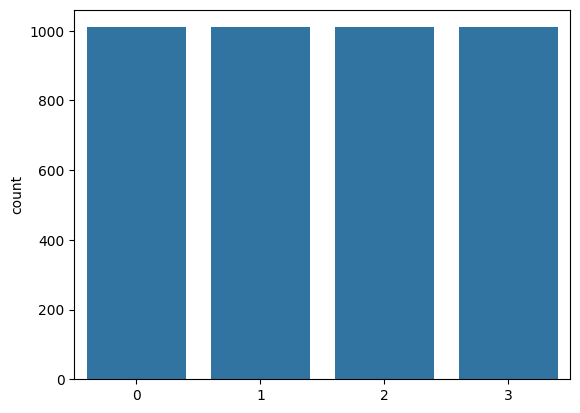

In [19]:
sb.countplot(x = y_test)

In [20]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16010, 128, 128, 3) (16010,)
(4040, 128, 128, 3) (4040,)


In [22]:
input_shape = (IMGSIZE, IMGSIZE, 3) #tuple
num_classes = 4

# Load the pre-trained ResNet50 model (without the top classification layer)
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

resnet_model = Sequential()

resnet_model.add(base_model)
resnet_model.add(Flatten())

resnet_model.add(Dense(256, activation = 'relu'))
resnet_model.add(Dropout(0.25))

resnet_model.add(Dense(128, activation = 'relu'))
resnet_model.add(Dropout(0.25))

resnet_model.add(Dense(64, activation = 'relu'))
resnet_model.add(Dense(num_classes, activation = 'softmax'))

resnet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
results = resnet_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 32, callbacks = [early_stopping])
# val_loss, val_acc = resnet_model.evaluate(X_test, y_test)

y_pred = resnet_model.predict(X_test)

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.7595 - loss: 1.3379 - val_accuracy: 0.8973 - val_loss: 0.2656
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9150 - loss: 0.2393 - val_accuracy: 0.9426 - val_loss: 0.1582
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9439 - loss: 0.1637 - val_accuracy: 0.9540 - val_loss: 0.1286
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9557 - loss: 0.1231 - val_accuracy: 0.9525 - val_loss: 0.1211
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9667 - loss: 0.0930 - val_accuracy: 0.9666 - val_loss: 0.0999
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9672 - loss: 0.0878 - val_accuracy: 0.9688 - val_loss: 0.0967
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9742 - loss: 0.0789 - val_accuracy: 0.9683 - val_loss: 0.0974
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,878,542 (186.46 MB)

 Trainable params: 8,430,276 (32.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,860,554 (64.32 MB)

In [24]:
resnet_model.save('./resnet_model.keras')

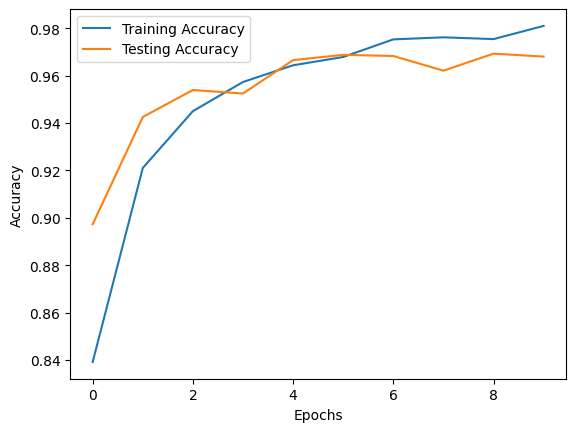

In [25]:
plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

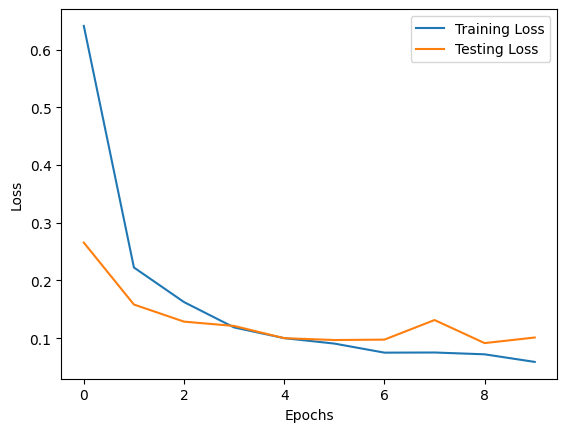

In [26]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
[1 2 1 0 1 0 2 2 0 2 2 1 0 3 3 3 1 3 0 2 0 3 3 2 0] 

[[4.0151281e-03 9.9561924e-01 3.6563404e-04 8.0508655e-11]
 [3.4270538e-11 3.8939284e-06 9.9999607e-01 6.2948130e-10]
 [8.7583729e-04 9.9462211e-01 4.5020245e-03 1.7136843e-09]
 [9.9998200e-01 1.7982249e-05 2.8104834e-08 1.0639933e-09]
 [1.7628041e-05 9.9998236e-01 8.8508889e-09 6.5549049e-20]
 [9.9998188e-01 1.8168434e-05 4.0756646e-08 1.4101752e-09]
 [4.1259359e-06 1.0817771e-02 9.8917806e-01 7.4357558e-08]
 [1.1204883e-11 2.2323647e-05 9.9997771e-01 1.1276697e-09]
 [9.9916291e-01 8.3198200e-04 4.5867473e-06 4.3154358e-07]
 [4.7831218e-11 1.5895418e-04 9.9984097e-01 1.5320052e-12]
 [4.7740507e-08 5.3094234e-04 9.9946910e-01 1.7781607e-08]
 [7.9052820e-04 9.9913555e-01 7.3908705e-05 8.5790300e-13]
 [1.0000000e+00 4.4415280e-09 2.5673691e-13 1.7294541e-15]
 [3.2035757e-39 2.4558143e-34 1.1924362e-38 1.0000000e+00]
 [1.0259907e-28 7.8320099e-24 4.0750677e-24 1.0000000e+00

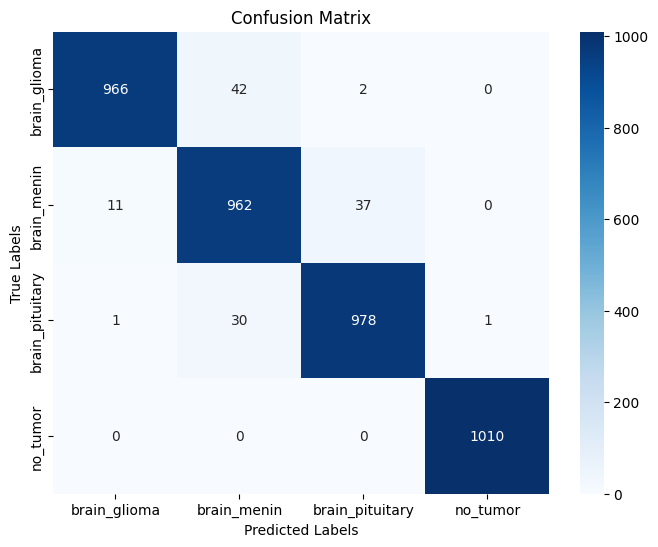

124.0 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1010
           1       0.93      0.95      0.94      1010
           2       0.96      0.97      0.96      1010
           3       1.00      1.00      1.00      1010

    accuracy                           0.97      4040
   macro avg       0.97      0.97      0.97      4040
weighted avg       0.97      0.97      0.97      4040



In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss

# your existing code
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

predict = []
for i in range(len(y_pred)):
    predict.append(np.argmax(y_pred[i]))

print(predict[:25], '\n')

cm = confusion_matrix(y_test, predict)
print(cm, '\n')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

zol = zero_one_loss(y_test, predict, normalize=False)
print(zol, '\n')

cr = classification_report(y_test, predict)
print(cr)


<Figure size 500x500 with 0 Axes>

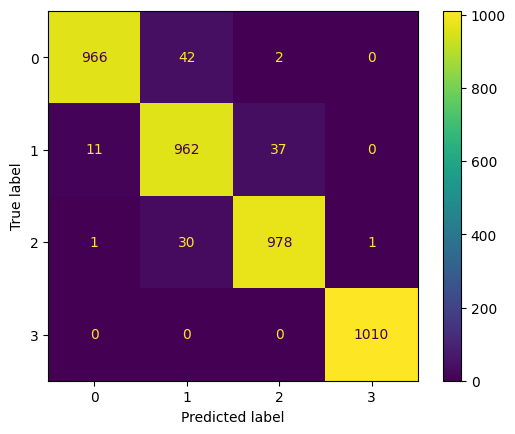

In [28]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

<Axes: ylabel='count'>

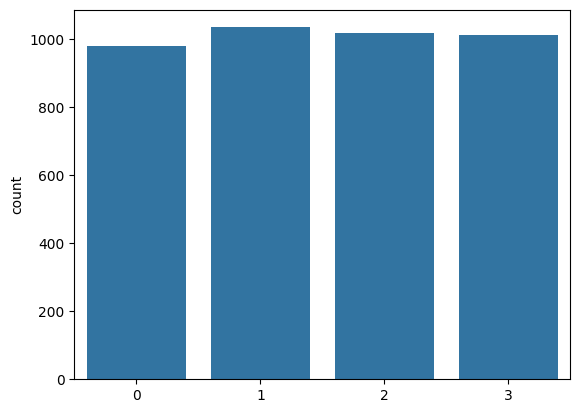

In [29]:
sb.countplot(x = predict)

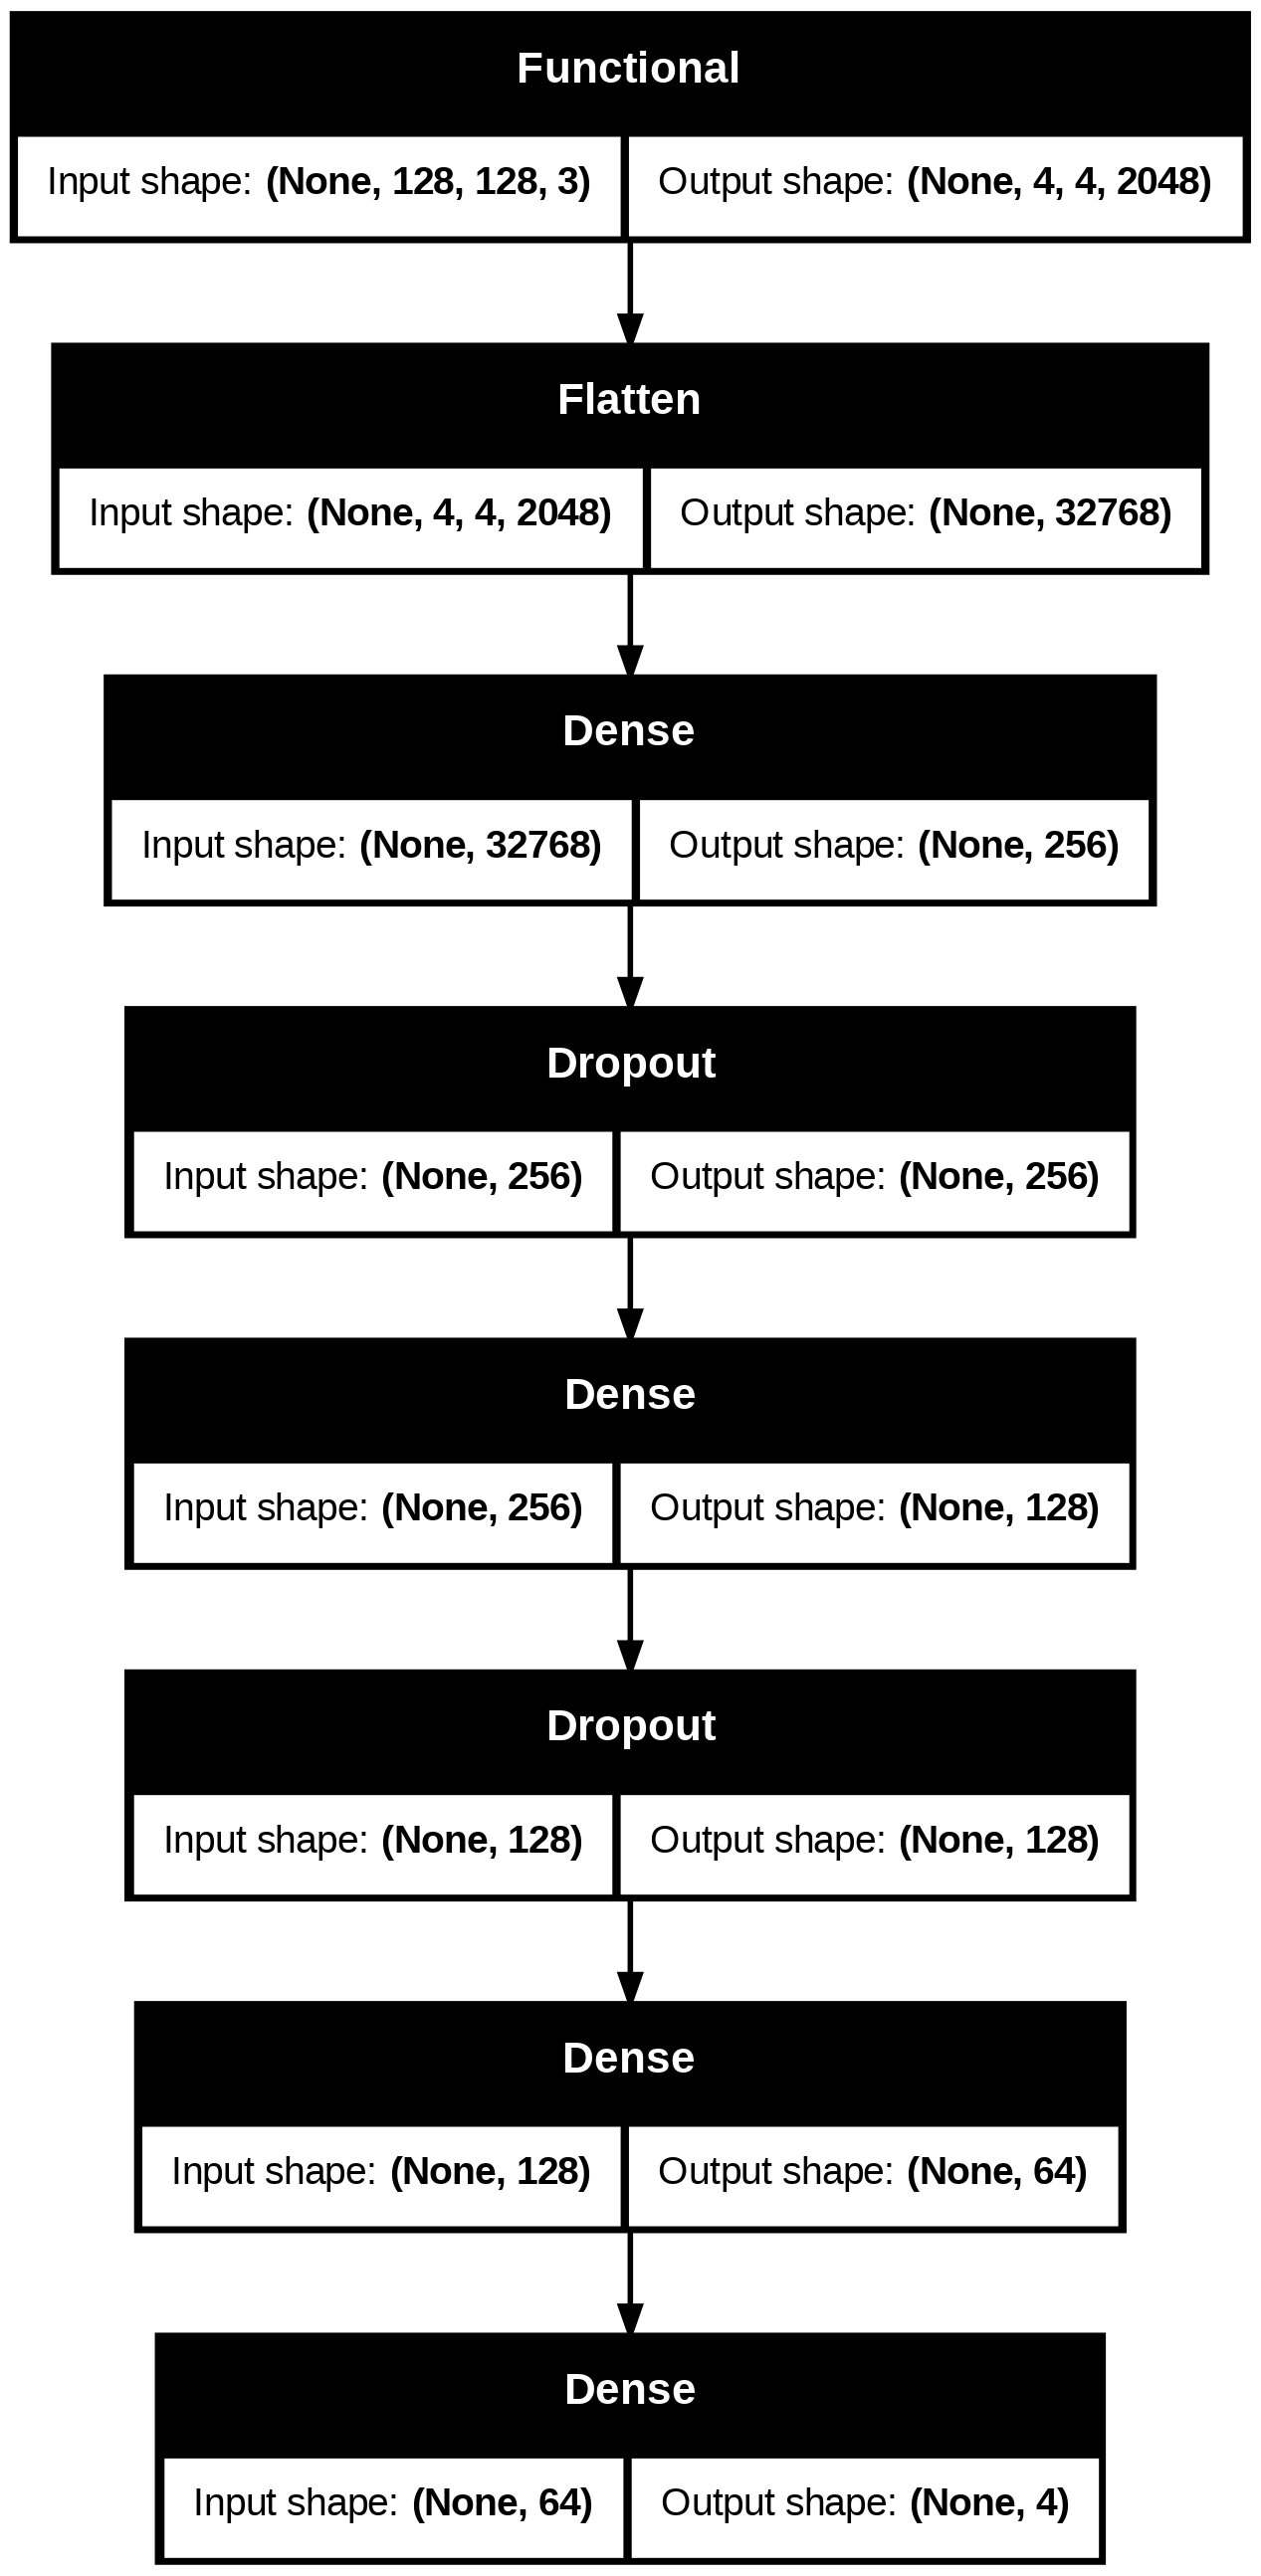

In [31]:
plot_model(resnet_model, show_shapes = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[9.9999952e-01 5.2949605e-07 2.1116719e-11 2.1625974e-12]]
['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


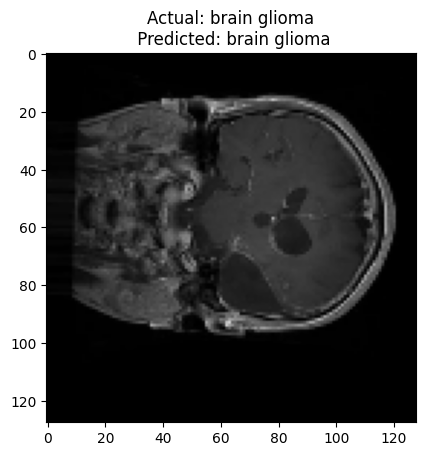

In [32]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

test_img_path = './image_dataset_(Brain)/test/brain_glioma/brain_glioma_4736.jpg'

test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (IMGSIZE, IMGSIZE))

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

test_img = test_img[tf.newaxis, ...]
test_predict = resnet_model.predict(test_img)

# Extract actual label from file name
filename = test_img_path.split(os.path.sep)[-1]
str1 = filename.split('_')[0]
str2 = filename.split('_')[1]

# Extract predicted class
predicted_class = classes[np.argmax(test_predict)]
str3 = predicted_class.split('_')[0] + ' ' + predicted_class.split('_')[1]

plt.title('Actual: ' + str1 + ' ' + str2 + '\n Predicted: ' + str3)

print(test_predict)
print(classes)
plt.show()


## EPOCHS 20

In [34]:
input_shape = (IMGSIZE, IMGSIZE, 3) #tuple
num_classes = 4

# Load the pre-trained ResNet50 model (without the top classification layer)
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

updated_resnet_model = Sequential()

updated_resnet_model.add(base_model)
updated_resnet_model.add(Flatten())

updated_resnet_model.add(Dense(256, activation = 'relu'))
updated_resnet_model.add(Dropout(0.25))

updated_resnet_model.add(Dense(128, activation = 'relu'))
updated_resnet_model.add(Dropout(0.25))

updated_resnet_model.add(Dense(64, activation = 'relu'))
updated_resnet_model.add(Dense(num_classes, activation = 'softmax'))

updated_resnet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
results = updated_resnet_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 32, callbacks = [early_stopping])
# val_loss, val_acc = resnet_model.evaluate(X_test, y_test)

y_pred = updated_resnet_model.predict(X_test)

updated_resnet_model.summary()

Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.7564 - loss: 1.4190 - val_accuracy: 0.9082 - val_loss: 0.2178
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9254 - loss: 0.2115 - val_accuracy: 0.9460 - val_loss: 0.1427
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9440 - loss: 0.1594 - val_accuracy: 0.9448 - val_loss: 0.1383
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9560 - loss: 0.1282 - val_accuracy: 0.9658 - val_loss: 0.1032
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9676 - loss: 0.0903 - val_accuracy: 0.9686 - val_loss: 0.0924
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9689 - loss: 0.0805 - val_accuracy: 0.9634 - val_loss: 0.1127
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9731 - loss: 0.0799 - val_accuracy: 0.9676 - val_loss: 0.0906
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9782 - loss: 0.0619 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,878,542 (186.46 MB)

 Trainable params: 8,430,276 (32.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,860,554 (64.32 MB)

In [35]:
updated_resnet_model.save('./updated_resnet_model.keras')

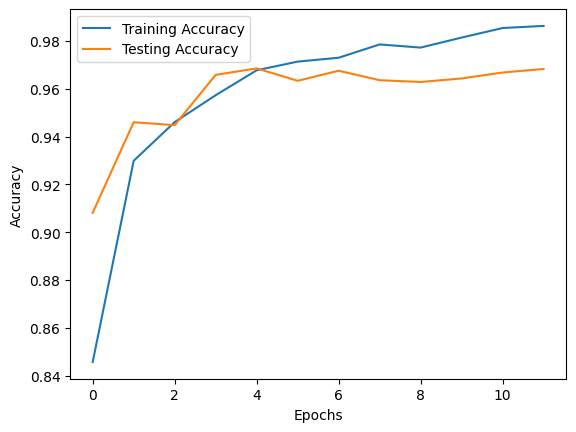

In [36]:
plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

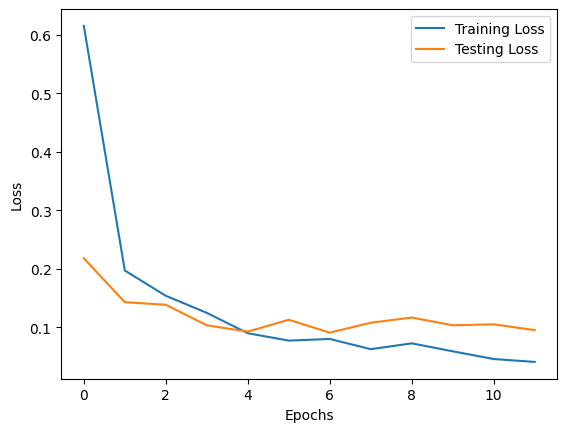

In [37]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
[1 2 1 0 1 0 2 2 0 2 2 1 0 3 3 3 1 3 0 2 0 3 3 2 0] 

[[4.66382178e-03 9.23873723e-01 7.14545026e-02 7.98040219e-06]
 [6.19129444e-12 3.85266940e-05 9.99961495e-01 2.16642669e-14]
 [1.98165188e-04 9.99754488e-01 4.73172913e-05 1.66968897e-10]
 [9.99968767e-01 3.06954134e-05 4.80494919e-07 8.16413603e-09]
 [9.09441269e-08 9.99999881e-01 1.36041836e-08 1.24547747e-18]
 [9.99995947e-01 4.05573473e-06 8.46635206e-09 2.33227149e-09]
 [2.88729005e-08 2.94563733e-03 9.97054338e-01 1.01704596e-10]
 [7.35477946e-15 3.19678020e-06 9.99996781e-01 2.03467918e-17]
 [9.99522328e-01 4.75709123e-04 1.42789713e-06 5.11604014e-07]
 [2.62427358e-10 1.10211072e-03 9.98897910e-01 1.71421543e-15]
 [1.21054333e-09 4.54516936e-04 9.99545515e-01 1.75617559e-11]
 [1.61201239e-03 9.98383522e-01 4.50364450e-06 3.74605486e-11]
 [1.00000000e+00 1.26098146e-10 2.12289320e-17 8.17030193e-15]
 [4.79566282e-28 1.47596270e-27 3.29958361e-26 1.00000000e+00]
 

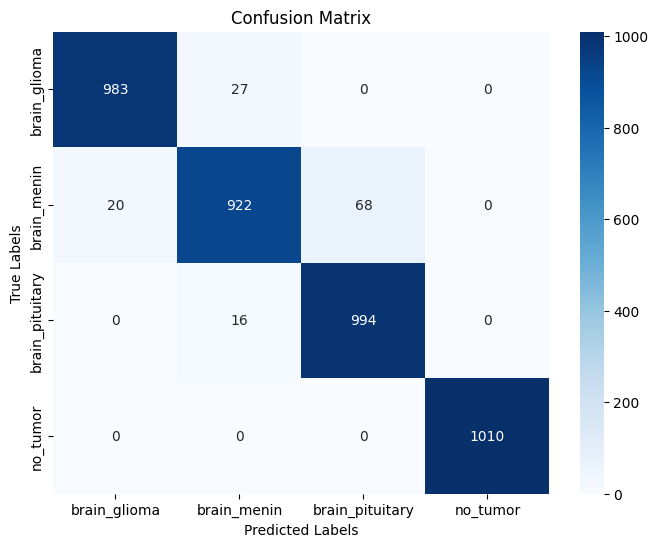

131.0 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1010
           1       0.96      0.91      0.93      1010
           2       0.94      0.98      0.96      1010
           3       1.00      1.00      1.00      1010

    accuracy                           0.97      4040
   macro avg       0.97      0.97      0.97      4040
weighted avg       0.97      0.97      0.97      4040



In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss

# your existing code
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

predict = []
for i in range(len(y_pred)):
    predict.append(np.argmax(y_pred[i]))

print(predict[:25], '\n')

cm = confusion_matrix(y_test, predict)
print(cm, '\n')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

zol = zero_one_loss(y_test, predict, normalize=False)
print(zol, '\n')

cr = classification_report(y_test, predict)
print(cr)


<Figure size 500x500 with 0 Axes>

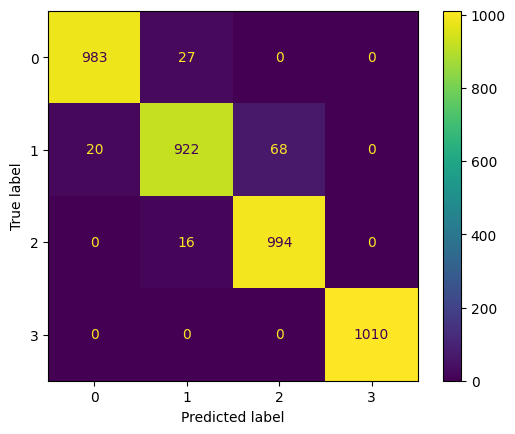

In [39]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

<Axes: ylabel='count'>

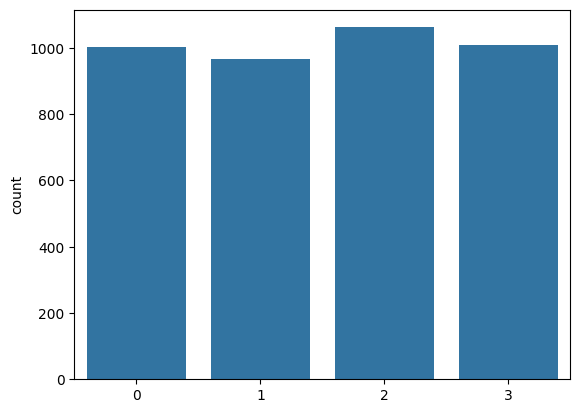

In [40]:
sb.countplot(x = predict)

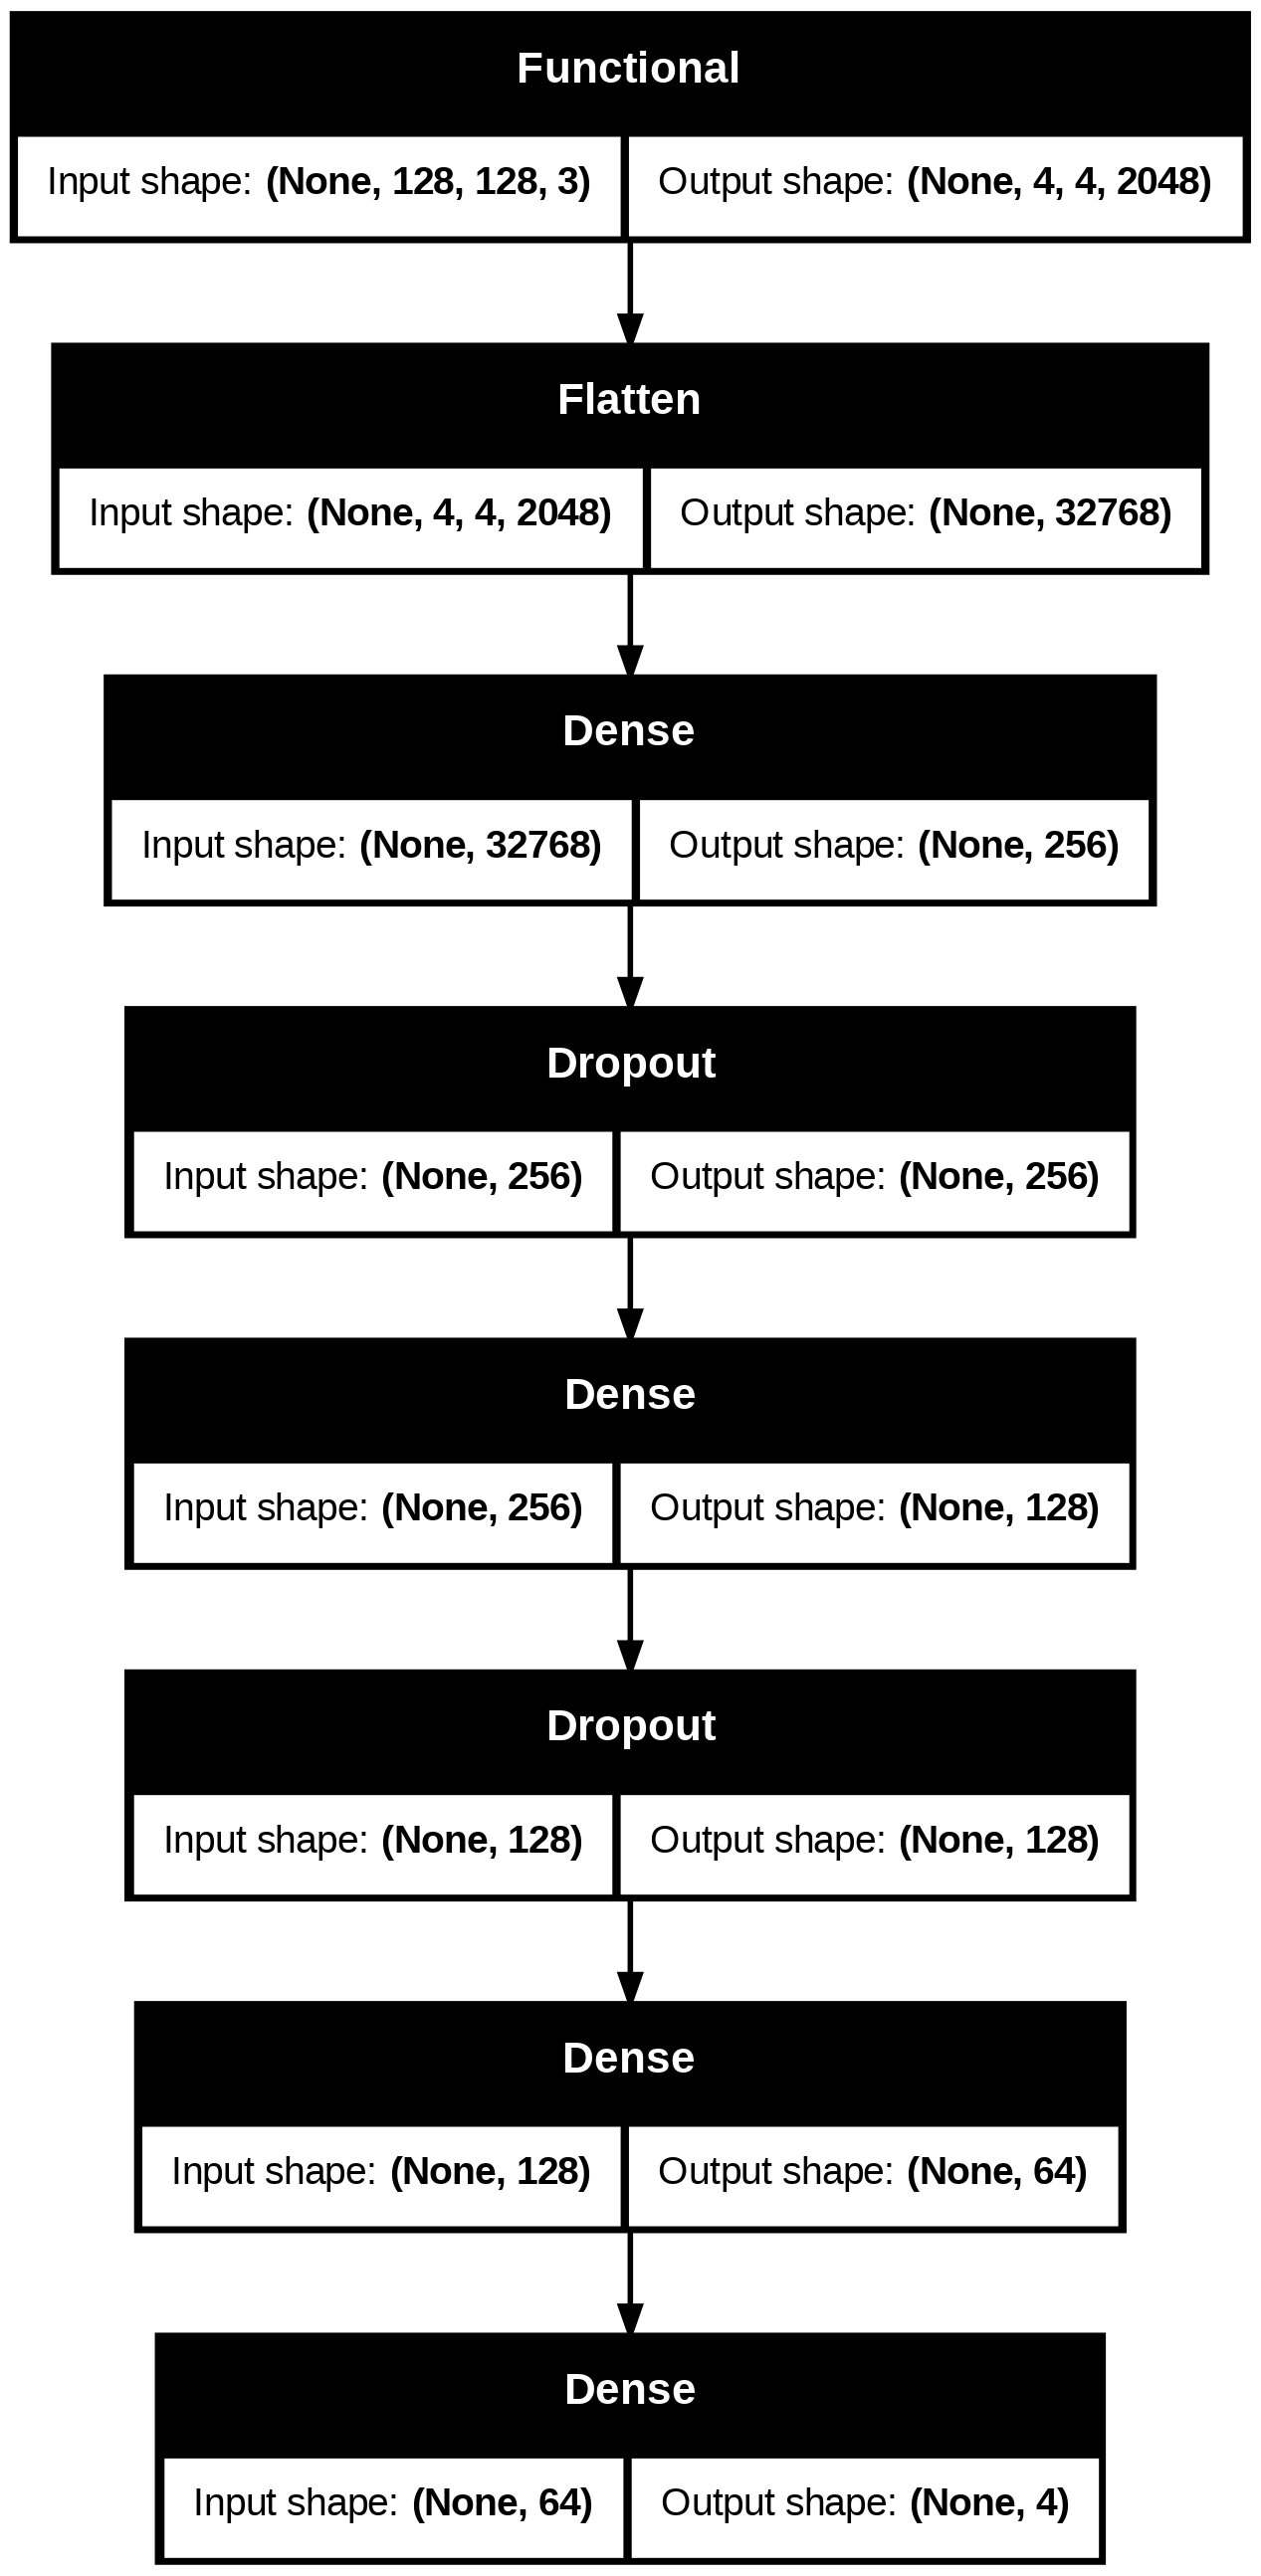

In [41]:
plot_model(updated_resnet_model, show_shapes = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[9.9999988e-01 8.9794298e-08 1.1387274e-11 1.1924064e-12]]
['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


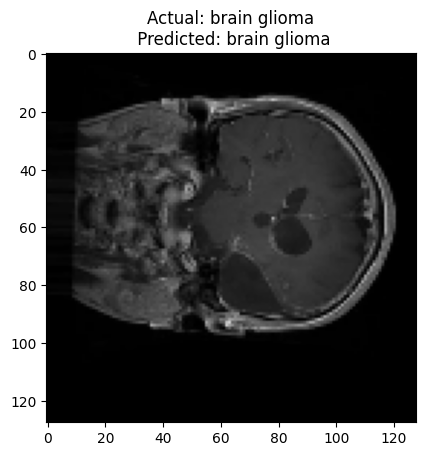

In [42]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

test_img_path = './image_dataset_(Brain)/test/brain_glioma/brain_glioma_4736.jpg'

test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (IMGSIZE, IMGSIZE))

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

test_img = test_img[tf.newaxis, ...]
test_predict = updated_resnet_model.predict(test_img)

# Extract actual label from file name
filename = test_img_path.split(os.path.sep)[-1]
str1 = filename.split('_')[0]
str2 = filename.split('_')[1]

# Extract predicted class
predicted_class = classes[np.argmax(test_predict)]
str3 = predicted_class.split('_')[0] + ' ' + predicted_class.split('_')[1]

plt.title('Actual: ' + str1 + ' ' + str2 + '\n Predicted: ' + str3)

print(test_predict)
print(classes)
plt.show()
